# ARIMAX Modeling

## Import libraries and read in data

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pylab import rcParams
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
warnings.filterwarnings("ignore")

In [8]:
model_df_sc = pd.read_csv('./Data/model_df_sc.csv')
model_df_sc['Date'] = pd.to_datetime(model_df_sc['Date'])
model_df_sc.set_index('Date', inplace=True)
model_df_sc.sort_index(inplace=True)

scaled_cols = ['Ward_1_Scaled', 'Ward_2_Scaled', 'Ward_3_Scaled', 'Ward_4_Scaled', 'Ward_5_Scaled',
              'Ward_6_Scaled', 'Ward_7_Scaled', 'Ward_8_Scaled', 'Avg_Temp_Scaled']
model_df_sc.columns = scaled_cols

model_df_sc.head()

,Ward_1_Scaled,Ward_2_Scaled,Ward_3_Scaled,Ward_4_Scaled,Ward_5_Scaled,Ward_6_Scaled,Ward_7_Scaled,Ward_8_Scaled,Avg_Temp_Scaled
Date,,,,,,,,,
2020-04-01,-0.367615,0.469052,-0.510369,-0.513593,-0.743528,-0.252121,-0.734432,-0.654435,-1.052801
2020-04-02,-0.453168,-0.311813,-0.349920,-0.448674,-0.178042,0.236170,0.090620,-0.654435,-0.618239
2020-04-03,0.145703,0.469052,-0.670817,0.525115,0.458131,0.654704,0.390639,0.126766,-0.428119
2020-04-04,-0.624273,-0.981126,-0.349920,-0.578513,-0.955586,-0.879922,-0.209399,0.623894,-0.591079
2020-04-05,-0.196509,0.692156,-0.029023,0.265438,-0.531471,1.142994,0.390639,-0.654435,-0.407749


In [9]:
# Reading in saved dataframe from 1_EDA_DC_Covid.ipynb and 2_Feature_Engineering.ipynb
model_df = pd.read_csv('./Data/model_df.csv')

# Setting Date index
model_df['Date'] = pd.to_datetime(model_df['Date'])
model_df.set_index('Date', inplace=True)
model_df.sort_index(inplace=True)
model_df.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases,Avg_Temp
Date,,,,,,,,,
2020-04-01,10.0,13.0,3.0,11.0,7.0,11.0,6.0,7.0,47.6
2020-04-02,9.0,6.0,4.0,12.0,15.0,18.0,17.0,7.0,54.0
2020-04-03,16.0,13.0,2.0,27.0,24.0,24.0,21.0,18.0,56.8
2020-04-04,7.0,0.0,4.0,10.0,4.0,2.0,13.0,25.0,54.4
2020-04-05,12.0,15.0,6.0,23.0,10.0,31.0,21.0,7.0,57.1


In [7]:
# # Standardizing all values from model_df and saving it as a new dataframe 
# ss = StandardScaler()
# ss = ss.fit(model_df)
# model_df_sc = ss.transform(model_df)
# model_df_sc = pd.DataFrame(model_df_sc, columns=scaled_cols, index=model_df.index)
# model_df_sc.head()

### Augmented Dickey Fuller Test

In [11]:
# Function infers whether data is stationary according to the p-value extracted from 
# Augmented Dickey Fuller test.

def get_p_value_adfuller(df, alpha=0.05):
    
    for col in df.columns:
        
        dftest = adfuller(df[col])
    
        if dftest[1] >= alpha:
            print(f'p-value for {col} is {dftest[1]} (greater than alpha {alpha}). Infer data is not stationary.\n')
           
        else:
            print(f'p-value for {col} is {dftest[1]} (smaller than alpha {alpha}). Infer data is stationary.\n')

#### ADF on model_df_sc

In [12]:
# None of the variables from the original model_df_sc dataframe appear stationary from the ADF test
get_p_value_adfuller(model_df_sc)

p-value for Ward_1_Scaled is 0.7377726355910947 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_2_Scaled is 0.8803395192028755 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_3_Scaled is 0.9783440609162192 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_4_Scaled is 0.7039304479629627 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_5_Scaled is 0.5383978060792167 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_6_Scaled is 0.9820970708777004 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_7_Scaled is 0.883447328125717 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_8_Scaled is 0.9055492910659668 (greater than alpha 0.05). Infer data is not stationary.

p-value for Avg_Temp_Scaled is 0.9320838184316185 (greater than alpha 0.05). Infer data is not stationary.



In [13]:
# The ADF test results infer that differencing the dataframe once makes all variables stationary. 
# Due to this result, I will assign all ARIMAX models d = 1 to indicate a one-time differencing of the data. 
get_p_value_adfuller(model_df_sc.diff().dropna())

p-value for Ward_1_Scaled is 1.141896883508389e-20 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_2_Scaled is 2.0435517516521206e-20 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_3_Scaled is 3.687967736948268e-07 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_4_Scaled is 1.889911038449074e-25 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_5_Scaled is 6.251562744454907e-22 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_6_Scaled is 7.417860818264311e-11 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_7_Scaled is 5.156062722160504e-12 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_8_Scaled is 0.0016383842566222362 (smaller than alpha 0.05). Infer data is stationary.

p-value for Avg_Temp_Scaled is 2.7878450527609255e-13 (smaller than alpha 0.05). Infer data is stationary.



## Train Test Split

In [26]:
# Splitting the model_df_sc data into train and test datasets
train_sc, test_sc = train_test_split(model_df_sc, train_size = 0.85, shuffle = False)
train, test = train_test_split(model_df, train_size = 0.85, shuffle = False)

## Grid Searching for p and q Values to Use in ARIMAX Model

In [27]:
# This function manually grid searches through p and q values to use when fitting an
# ARIMAX model, ultimately identifying the combination that provides the smallest AIC score.
# d will equal 1 due to the results of the previous ADF test on the data.
# Code is partially derived from General Assembly's ARIMA Time Series lesson. 

def grid_search_p_and_q(endog, exog, p_list, q_list):
    # Starting AIC, p, and q.
    best_aic = 100_000_000
    best_p = 0
    best_q = 0
    for p in p_list:
        for q in q_list:
            # order --> 
            # p = (AutoRegressive), captures dependence on prev vals (how many lags back?)
            # d = (Integrated), how many times to diff the data to give stationarity
            # q = (MovingAverage), captures dependence on past error (how many lags back?)
            arimax = ARIMA(endog = endog.astype(float).dropna(),
                           exog = exog,
                           order = (p,1,q))
            model = arimax.fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q
        print(f'{p} out of {len(p_list)} complete')

    order = (best_p, 1, best_q)
    
    print()
    print(f'FINISHED: ARIMAX({order}) gives the smallest AIC when fitted with the training data.')
    print(f'This model has an AIC of {best_aic}.')
    return order

In [28]:
# ARIMAX((4, 1, 3)) --> value lag window of 4, difference 1 time, error lag window of 3
p_q_gs_ward_1_scaled = grid_search_p_and_q(endog = train_sc['Ward_1_Scaled'], 
                                           exog = train_sc['Avg_Temp_Scaled'], 
                                           p_list = range(6), 
                                           q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((4, 1, 3)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 462.0215750611344.


In [29]:
p_q_gs_ward_2_scaled = grid_search_p_and_q(endog = train_sc['Ward_2_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((4, 1, 5)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 416.52862194652084.


In [30]:
p_q_gs_ward_3_scaled = grid_search_p_and_q(endog = train_sc['Ward_3_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((3, 1, 2)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 475.98461280792014.


In [31]:
p_q_gs_ward_4_scaled = grid_search_p_and_q(endog = train_sc['Ward_4_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((2, 1, 3)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 445.2949449192762.


In [32]:
p_q_gs_ward_5_scaled = grid_search_p_and_q(endog = train_sc['Ward_5_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((4, 1, 5)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 387.666038997119.


In [33]:
p_q_gs_ward_6_scaled = grid_search_p_and_q(endog = train_sc['Ward_6_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((3, 1, 5)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 301.32707534139337.


In [34]:
p_q_gs_ward_7_scaled = grid_search_p_and_q(endog = train_sc['Ward_7_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(3))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((3, 1, 2)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 414.04668060553297.


In [35]:
p_q_gs_ward_8_scaled = grid_search_p_and_q(endog = train_sc['Ward_8_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(3), 
                                    q_list = range(6))

0 out of 3 complete
1 out of 3 complete
2 out of 3 complete

FINISHED: ARIMAX((2, 1, 5)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 446.11203779074106.


## Standard Forecast Predictions

In [37]:
def get_arimax_forecast(train, test, endog_var, exog_var, order, forecast_steps):
    
    # Setting endogenous variable values to use when fitting model
    endog_train = train[endog_var]
    
    # Setting exogenous variable values to use when fitting model
    exog_train = train[exog_var]
    
    # Setting exogenous variable values to compare with the model's predictions
    exog_test = test[exog_var]
    
    # Fitting ARIMAX model
    arimax = ARIMA(endog = endog_train, 
                  exog = exog_train,
                  dates = train.index, 
                  order = order).fit()
    
    # Forecasting endogenous variable values
    arimax_forecast = arimax.forecast(steps = forecast_steps, exog=exog_test)
    
    return arimax_forecast[0]

In [72]:
# Function to transform scaled predictions back to the scale of the original dataframe
def inverse_transform_preds(original_var, original_df, scaled_preds, index):
    
    feature = original_df[original_var].values.reshape(-1, 1)
    ss = StandardScaler()
    feat_scaled = ss.fit_transform(feature)
    predictions = ss.inverse_transform(scaled_preds)
    predictions = pd.Series(predictions.flatten(), index=index)
    
    return predictions

In [ ]:
ward_1_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_1_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_1_scaled,
                                             forecast_steps=len(test_sc))

ward_1_inverse_forecast = inverse_transform_preds('Ward_1_Cases', 
                                                   model_df, 
                                    scaled_preds = np.array(ward_1_arimax_forecast_scaled).reshape(-1,1), 
                                    index = test_sc.index[:1])

In [93]:
ward_2_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_2_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_2_scaled,
                                             forecast_steps=len(test_sc))

ward_2_inverse_forecast = inverse_transform_preds('Ward_2_Cases', 
                                                   model_df, 
                                    scaled_preds = np.array(ward_2_arimax_forecast_scaled).reshape(-1,1), 
                                    index = test_sc.index[:1])

In [94]:
ward_3_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_3_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_3_scaled,
                                             forecast_steps=len(test_sc))

ward_3_inverse_forecast = inverse_transform_preds('Ward_3_Cases', 
                                                   model_df, 
                                    scaled_preds = np.array(ward_3_arimax_forecast_scaled).reshape(-1,1), 
                                    index = test_sc.index[:1])

In [95]:
ward_4_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_4_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_4_scaled,
                                             forecast_steps=len(test_sc))

ward_4_inverse_forecast = inverse_transform_preds('Ward_4_Cases', 
                                                   model_df, 
                                    scaled_preds = np.array(ward_4_arimax_forecast_scaled).reshape(-1,1), 
                                    index = test_sc.index[:1])

In [96]:
ward_5_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_5_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_5_scaled,
                                             forecast_steps=len(test_sc))

ward_5_inverse_forecast = inverse_transform_preds('Ward_5_Cases', 
                                                   model_df, 
                                    scaled_preds = np.array(ward_5_arimax_forecast_scaled).reshape(-1,1), 
                                    index = test_sc.index[:1])

In [97]:
ward_6_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_6_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_6_scaled,
                                             forecast_steps=len(test_sc))

ward_6_inverse_forecast = inverse_transform_preds('Ward_6_Cases', 
                                                   model_df, 
                                    scaled_preds = np.array(ward_6_arimax_forecast_scaled).reshape(-1,1), 
                                    index = test_sc.index[:1])

In [98]:
ward_7_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_7_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_7_scaled,
                                             forecast_steps=len(test_sc))

ward_7_inverse_forecast = inverse_transform_preds('Ward_7_Cases', 
                                                   model_df, 
                                    scaled_preds = np.array(ward_7_arimax_forecast_scaled).reshape(-1,1), 
                                    index = test_sc.index[:1])

In [99]:
ward_8_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_8_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_8_scaled,
                                             forecast_steps=len(test_sc))

ward_8_inverse_forecast = inverse_transform_preds('Ward_8_Cases', 
                                                   model_df, 
                                    scaled_preds = np.array(ward_8_arimax_forecast_scaled).reshape(-1,1), 
                                    index = test_sc.index[:1])

### Rolling Forecast Predictions

In [100]:
def get_rolling_scaled_preds(train, test, endog_var, exog_var, order):

    predictions = []
    history_endog = list(train[endog_var])
    history_exog = list(train[exog_var])
    test_endog = test[endog_var]
    test_exog = test[exog_var]

    for t in range(len(test)):
        model_fit = ARIMA(endog=history_endog,
                          exog=history_exog,
                          dates=train.index,
                          order=order).fit()
        yhat = model_fit.forecast(steps=1, exog=test_exog[t])[0]
        predictions.append(yhat)
        history_endog.append(test_endog[t])
        history_exog.append(test_exog[t])

    return predictions

In [102]:
ward_1_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_1_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_1_scaled)

ward_1_inverse_sc_preds = inverse_transform_preds('Ward_1_Cases', 
                                    model_df, 
                                    scaled_preds = np.array(ward_1_rolling_scaled_preds).reshape(-1,1), 
                                    index = test_sc.index)

In [103]:
ward_2_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_2_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_2_scaled)

ward_2_inverse_sc_preds = inverse_transform_preds('Ward_2_Cases', 
                                    model_df, 
                                    scaled_preds = np.array(ward_2_rolling_scaled_preds).reshape(-1,1), 
                                    index = test_sc.index)

In [104]:
ward_3_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_3_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_3_scaled)

ward_3_inverse_sc_preds = inverse_transform_preds('Ward_3_Cases', 
                                    model_df, 
                                    scaled_preds = np.array(ward_3_rolling_scaled_preds).reshape(-1,1), 
                                    index = test_sc.index)

In [105]:
ward_4_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_4_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_4_scaled)

ward_4_inverse_sc_preds = inverse_transform_preds('Ward_4_Cases', 
                                    model_df, 
                                    scaled_preds = np.array(ward_4_rolling_scaled_preds).reshape(-1,1), 
                                    index = test_sc.index)

In [106]:
ward_5_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_5_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_5_scaled)

ward_5_inverse_sc_preds = inverse_transform_preds('Ward_5_Cases', 
                                    model_df, 
                                    scaled_preds = np.array(ward_5_rolling_scaled_preds).reshape(-1,1), 
                                    index = test_sc.index)

In [107]:
ward_6_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_6_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_6_scaled)

ward_6_inverse_sc_preds = inverse_transform_preds('Ward_6_Cases', 
                                    model_df, 
                                    scaled_preds = np.array(ward_6_rolling_scaled_preds).reshape(-1,1), 
                                    index = test_sc.index)

In [108]:
ward_7_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_7_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_7_scaled)

ward_7_inverse_sc_preds = inverse_transform_preds('Ward_7_Cases', 
                                    model_df, 
                                    scaled_preds = np.array(ward_7_rolling_scaled_preds).reshape(-1,1), 
                                    index = test_sc.index)

In [109]:
ward_8_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_8_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_8_scaled)

ward_8_inverse_sc_preds = inverse_transform_preds('Ward_8_Cases', 
                                    model_df, 
                                    scaled_preds = np.array(ward_8_rolling_scaled_preds).reshape(-1,1), 
                                    index = test_sc.index)

## Plot ARIMAX Results

In [124]:
def plot_std_and_roll_preds(train, test, ward_no, std_preds, roll_preds):
    
    plt.figure(figsize=(14, 7))
    
    # plt.subplot(211)
    # plt.plot(train[f'Ward_{str(ward_no)}_Cases'])
    # plt.plot(test[f'Ward_{str(ward_no)}_Cases'])
    # plt.plot(std_preds)
    # plt.ylabel('Daily Cases', fontsize=14)
    # plt.legend(['Train Values', 'Test Values', 'Predictions'], loc='upper left')
    # plt.title(f'Ward {str(ward_no)} Daily Cases One-Time Predictions vs Actual', fontsize=20)
    
    plt.subplot(111)
    plt.plot(train[f'Ward_{str(ward_no)}_Cases'])
    plt.plot(test[f'Ward_{str(ward_no)}_Cases'])
    plt.plot(roll_preds)
    plt.ylabel('Daily Cases', fontsize=14)
    plt.legend(['Train Values', 'Test Values', 'Predictions'], loc='upper left')
    plt.title(f'Ward {str(ward_no)} Daily Cases Rolling Predictions vs Actual', fontsize=20)
    
    plt.tight_layout();

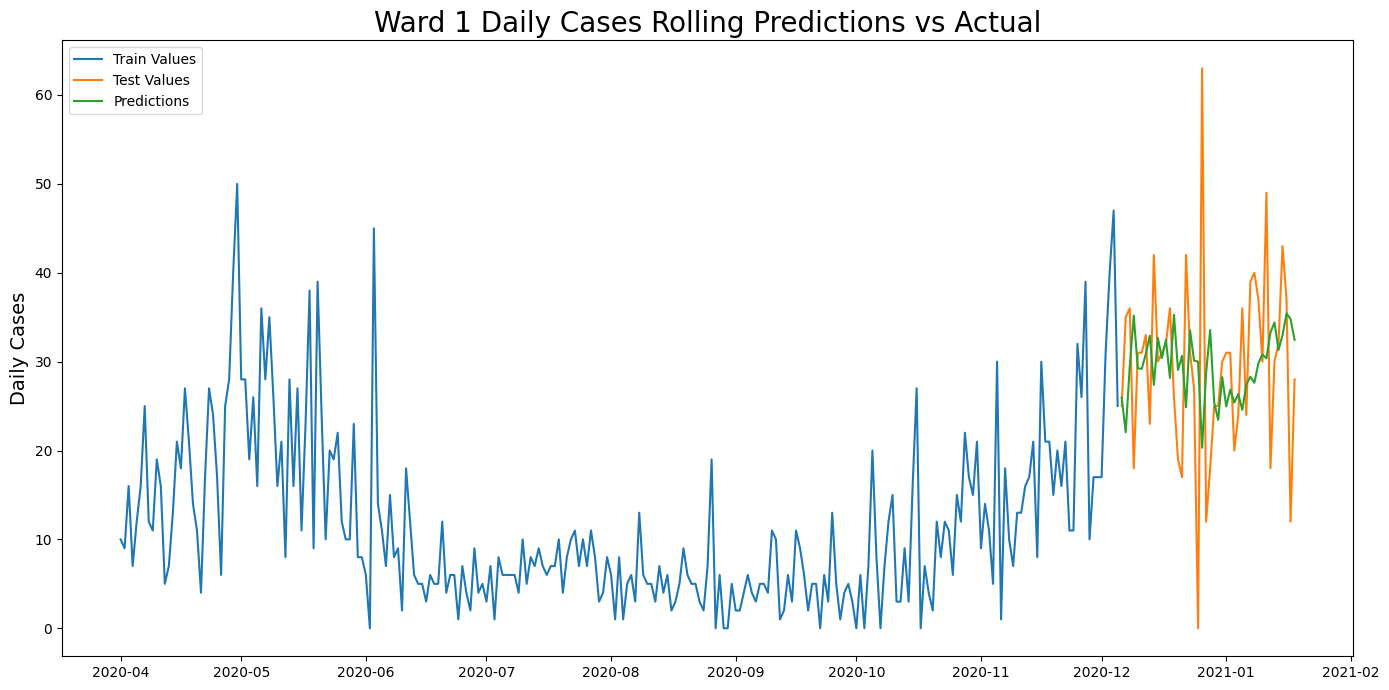

In [125]:
plot_std_and_roll_preds(train, test, 1, std_preds= ward_1_inverse_forecast, 
                        roll_preds = ward_1_inverse_sc_preds)

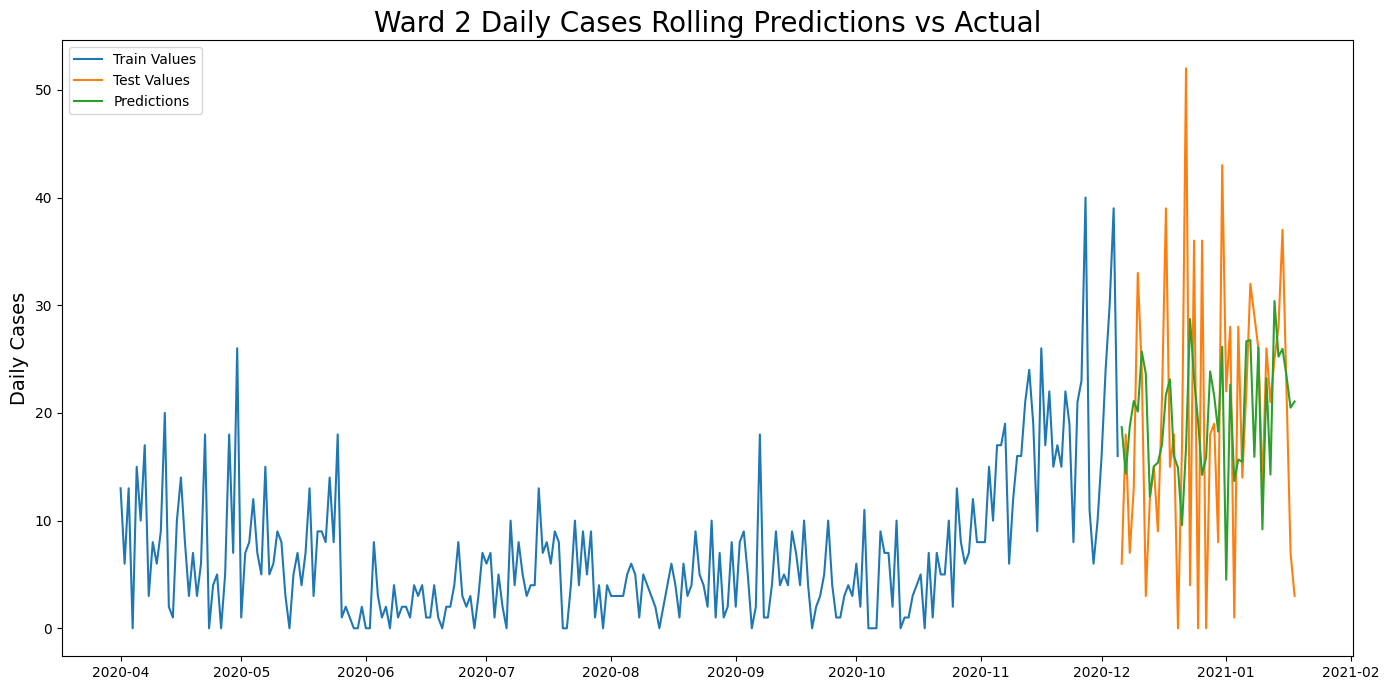

In [126]:
plot_std_and_roll_preds(train, test, 2, std_preds= ward_2_inverse_forecast, 
                        roll_preds = ward_2_inverse_sc_preds)

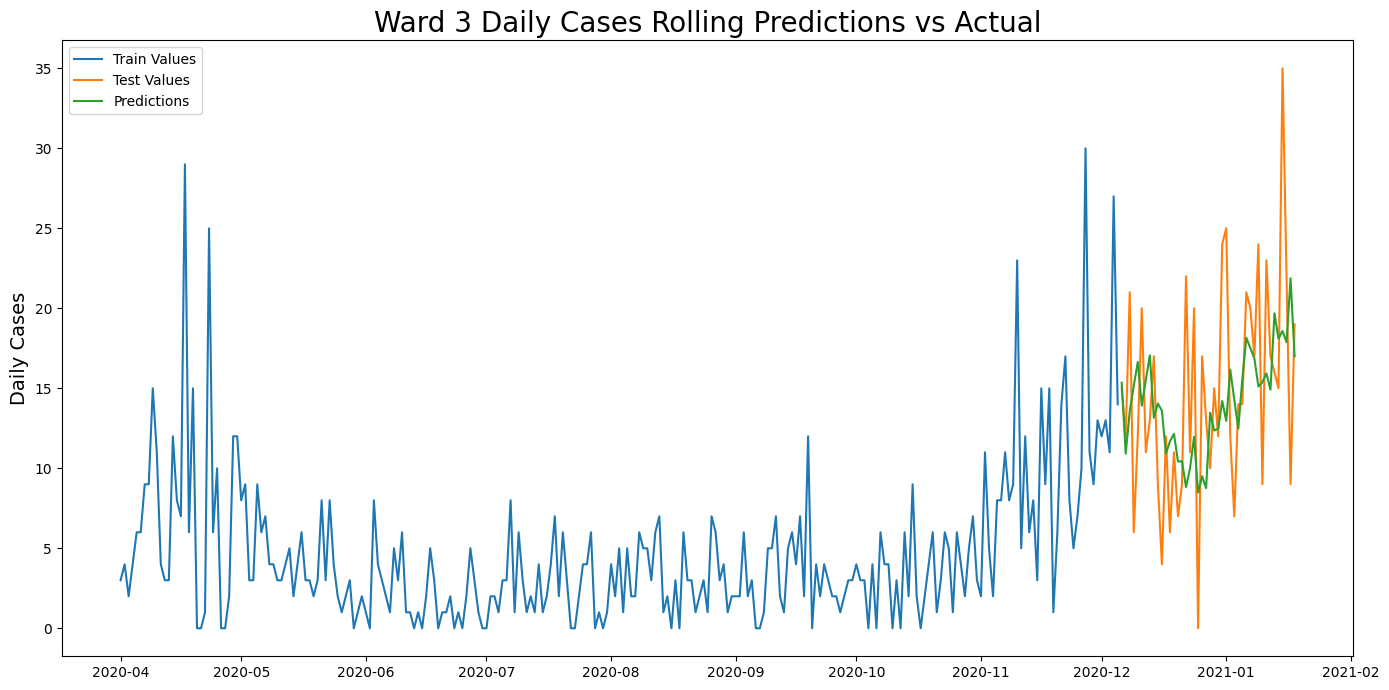

In [127]:
plot_std_and_roll_preds(train, test, 3, std_preds= ward_3_inverse_forecast, 
                        roll_preds = ward_3_inverse_sc_preds)

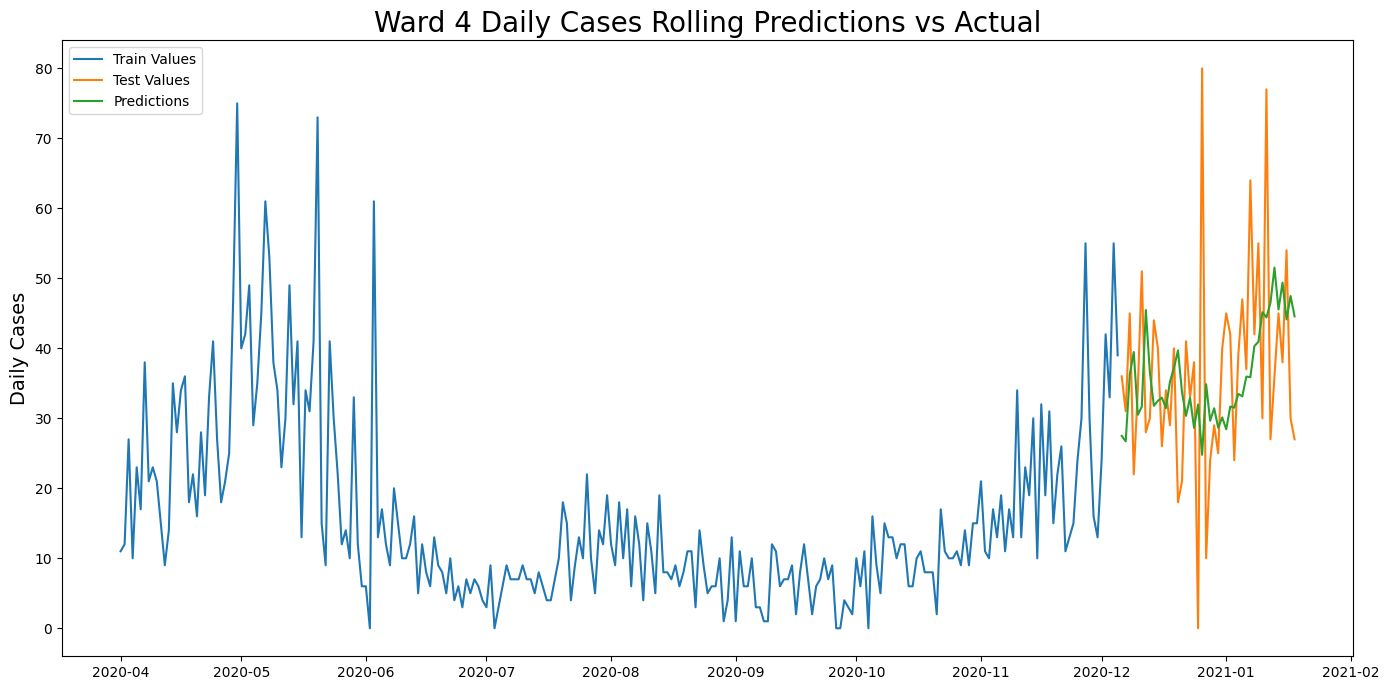

In [128]:
plot_std_and_roll_preds(train, test, 4, std_preds= ward_4_inverse_forecast, 
                        roll_preds = ward_4_inverse_sc_preds)

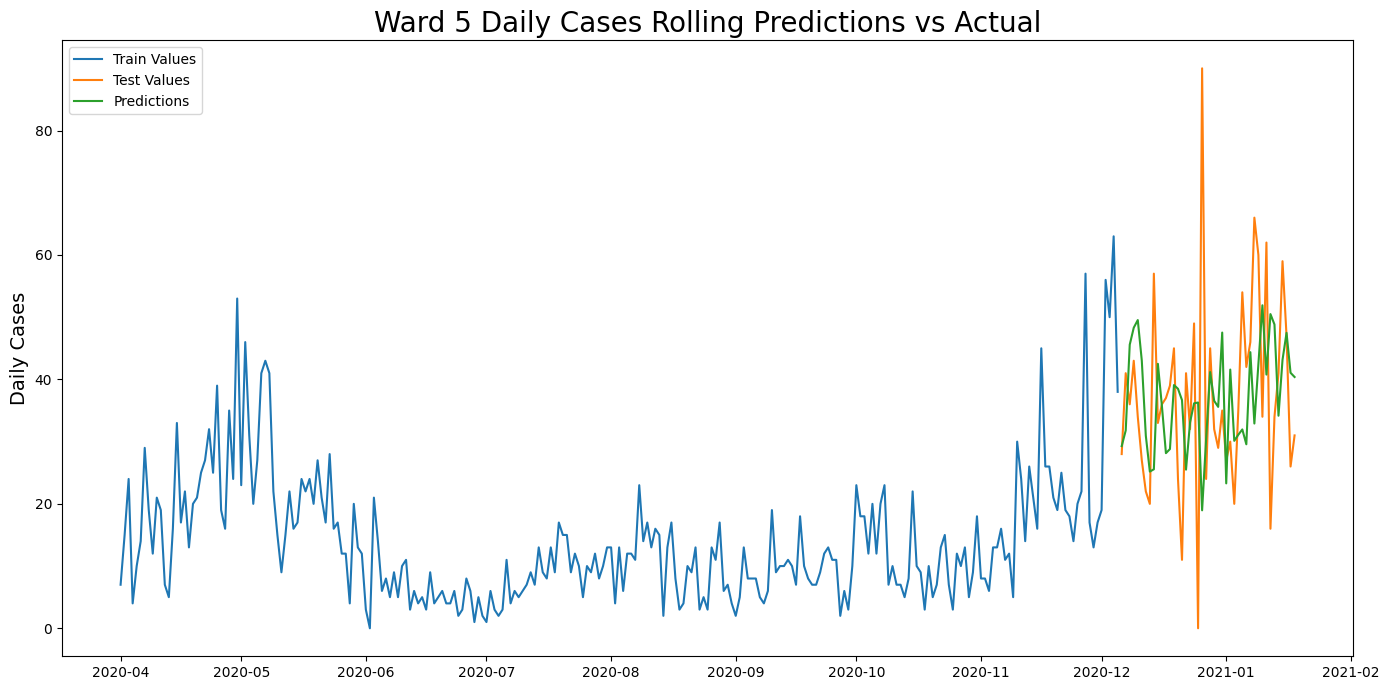

In [129]:
plot_std_and_roll_preds(train, test, 5, std_preds= ward_5_inverse_forecast, 
                        roll_preds = ward_5_inverse_sc_preds)

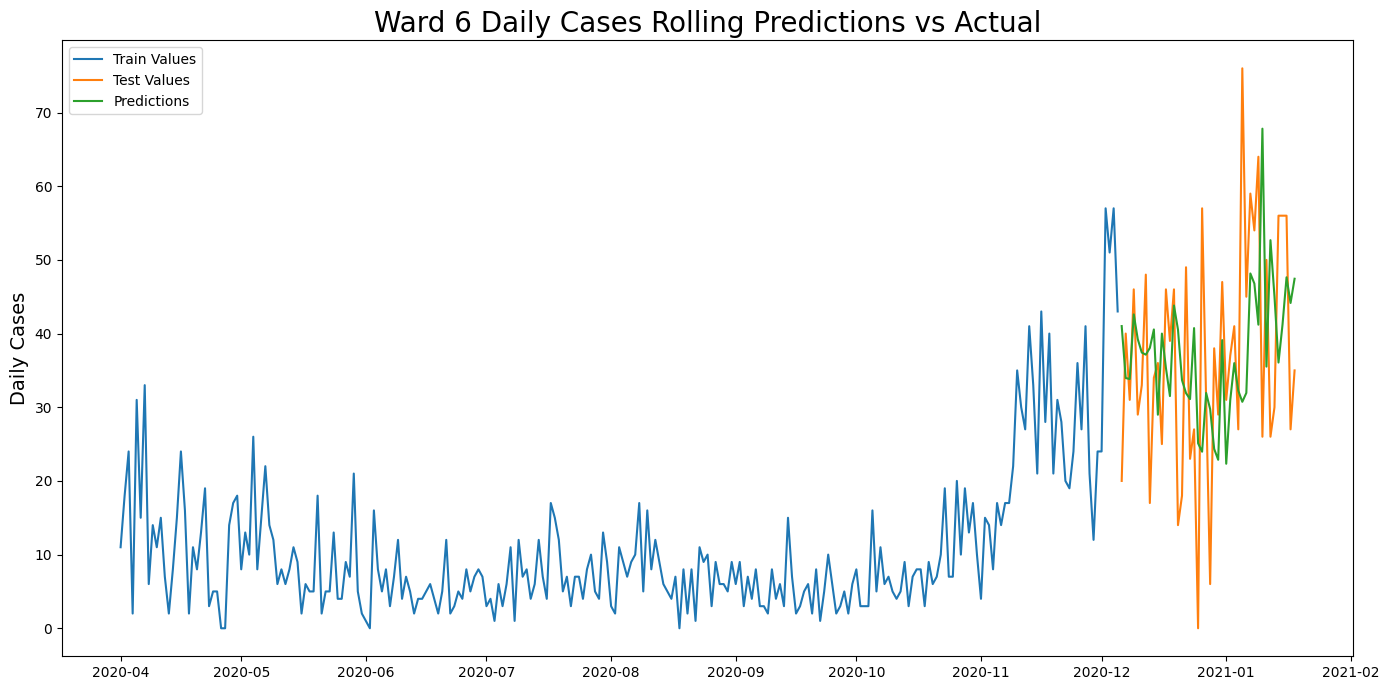

In [130]:
plot_std_and_roll_preds(train, test, 6, std_preds= ward_6_inverse_forecast, 
                        roll_preds = ward_6_inverse_sc_preds)

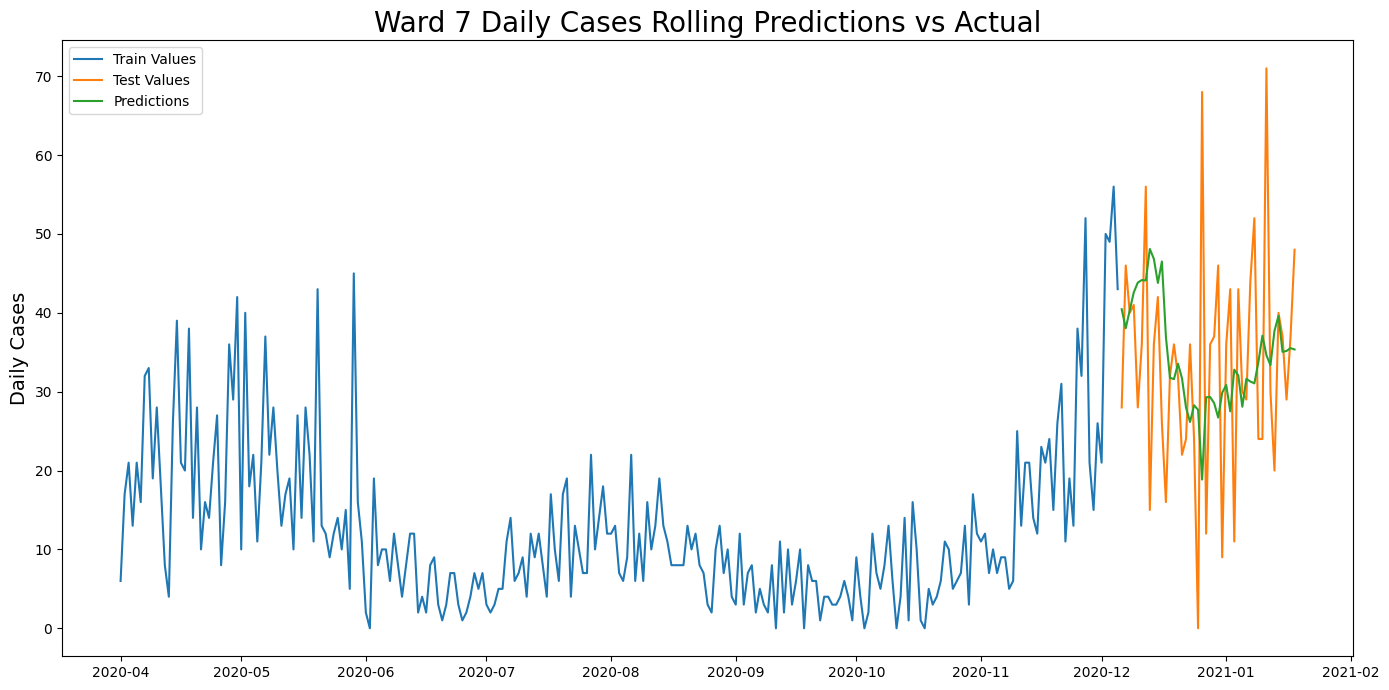

In [131]:
plot_std_and_roll_preds(train, test, 7, std_preds= ward_7_inverse_forecast, 
                        roll_preds = ward_7_inverse_sc_preds)

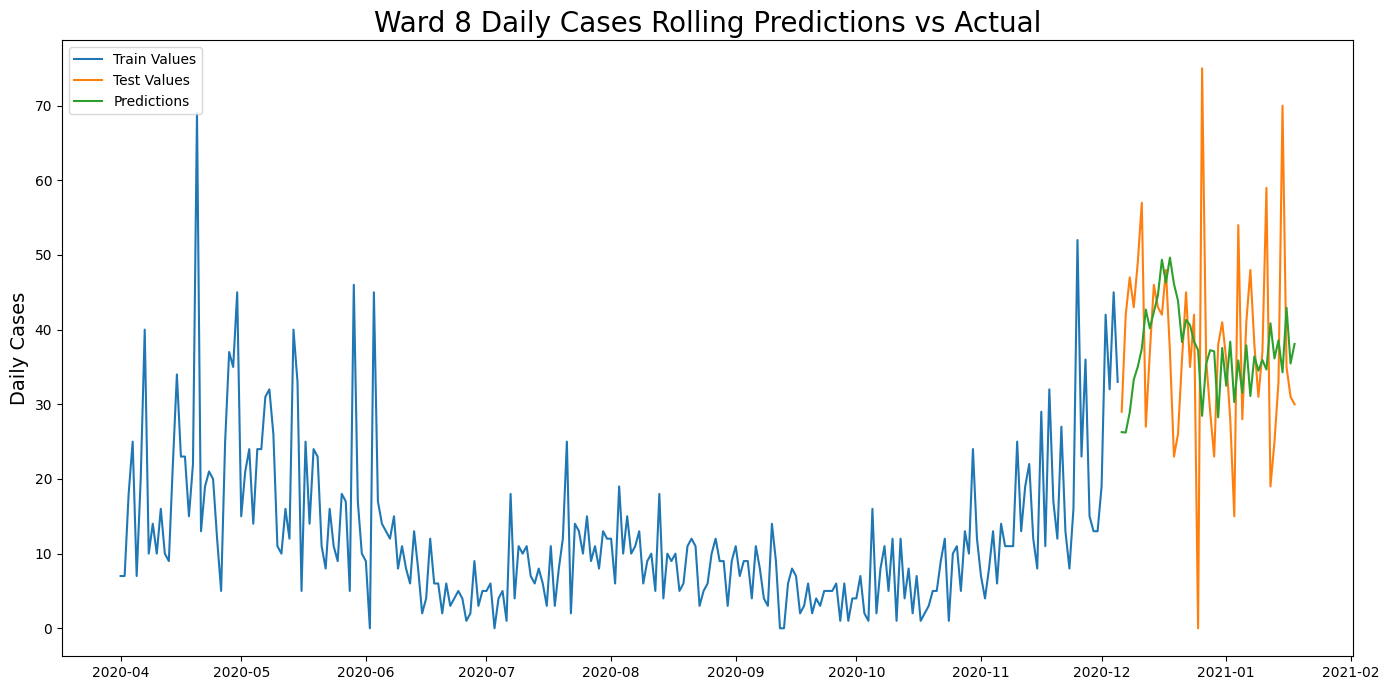

In [132]:
plot_std_and_roll_preds(train, test, 8, std_preds= ward_8_inverse_forecast, 
                        roll_preds = ward_8_inverse_sc_preds)

## Get RMSE for Each Ward

In [140]:
def get_rmse_scores(test, ward_list):
    
    ward_pred_dict = {1:[ward_1_inverse_forecast, ward_1_inverse_sc_preds], 
                      2:[ward_2_inverse_forecast, ward_2_inverse_sc_preds], 
                      3:[ward_3_inverse_forecast, ward_3_inverse_sc_preds], 
                      4:[ward_4_inverse_forecast, ward_4_inverse_sc_preds], 
                      5:[ward_5_inverse_forecast, ward_5_inverse_sc_preds], 
                      6:[ward_6_inverse_forecast, ward_6_inverse_sc_preds], 
                      7:[ward_7_inverse_forecast, ward_7_inverse_sc_preds], 
                      8:[ward_8_inverse_forecast, ward_8_inverse_sc_preds]}
        
    for ward in ward_list:
        for key, pred in ward_pred_dict.items():
            if ward == key:
                
                # rmse_forecast = root_mean_squared_error(test[f'Ward_{str(ward)}_Cases'], pred[0])
                rmse_rolling_pred = root_mean_squared_error(test[f'Ward_{str(ward)}_Cases'], pred[1])
                
                print(f'Rolling predictions RMSE for Ward {ward}: {rmse_rolling_pred}')
                print('--'*30)

In [141]:
get_rmse_scores(test, [1, 2, 3, 4, 5, 6, 7, 8])

Rolling predictions RMSE for Ward 1: 12.271786353889873
------------------------------------------------------------
Rolling predictions RMSE for Ward 2: 12.448766468958407
------------------------------------------------------------
Rolling predictions RMSE for Ward 3: 6.405264812078731
------------------------------------------------------------
Rolling predictions RMSE for Ward 4: 16.23514444281164
------------------------------------------------------------
Rolling predictions RMSE for Ward 5: 18.54376597352799
------------------------------------------------------------
Rolling predictions RMSE for Ward 6: 17.087225875352967
------------------------------------------------------------
Rolling predictions RMSE for Ward 7: 15.810496611644286
------------------------------------------------------------
Rolling predictions RMSE for Ward 8: 15.259746755486837
------------------------------------------------------------


In [144]:
resids_1 = test['Ward_1_Cases'] - ward_1_inverse_sc_preds
resids_2 = test['Ward_2_Cases'] - ward_2_inverse_sc_preds
resids_3 = test['Ward_3_Cases'] - ward_3_inverse_sc_preds
resids_4 = test['Ward_4_Cases'] - ward_4_inverse_sc_preds
resids_5 = test['Ward_5_Cases'] - ward_5_inverse_sc_preds
resids_6 = test['Ward_6_Cases'] - ward_6_inverse_sc_preds
resids_7 = test['Ward_7_Cases'] - ward_7_inverse_sc_preds
resids_8 = test['Ward_8_Cases'] - ward_8_inverse_sc_preds

In [145]:
def plot_resids(ward_no, resids):
    
    plt.figure(figsize=(18,7))

    # Create residual scatterplot
    plt.scatter(test.index, resids, c ='green')

    # Plot horizontal line at y=0.
    plt.hlines(y = 0,
               xmin = test.index.min(),
               xmax = test.index.max(),
               linestyles = '--')

    # Set labels and axes.
    plt.title(f'Modeling Net New Daily Cases -- Prediction Errors for Ward {str(ward_no)}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Residuals', fontsize = 16)
    plt.ylim([-50, 50]);

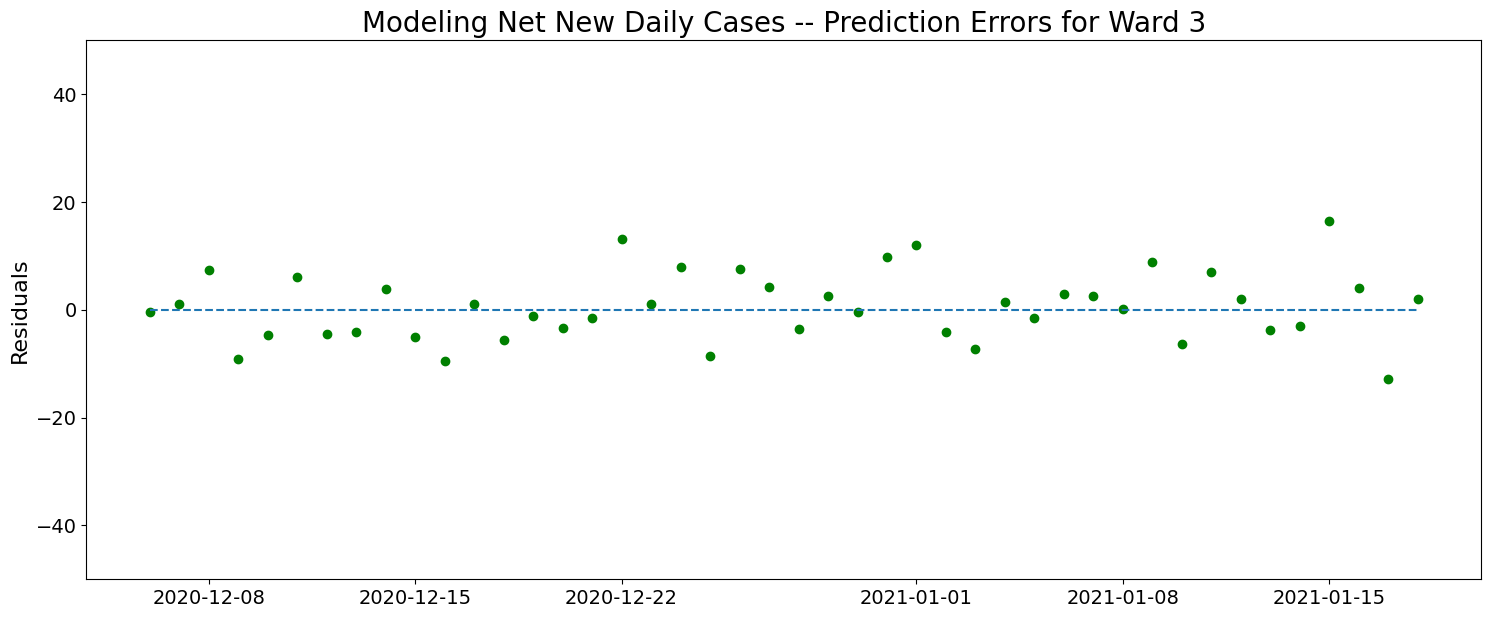

In [146]:
plot_resids(3, resids_3)

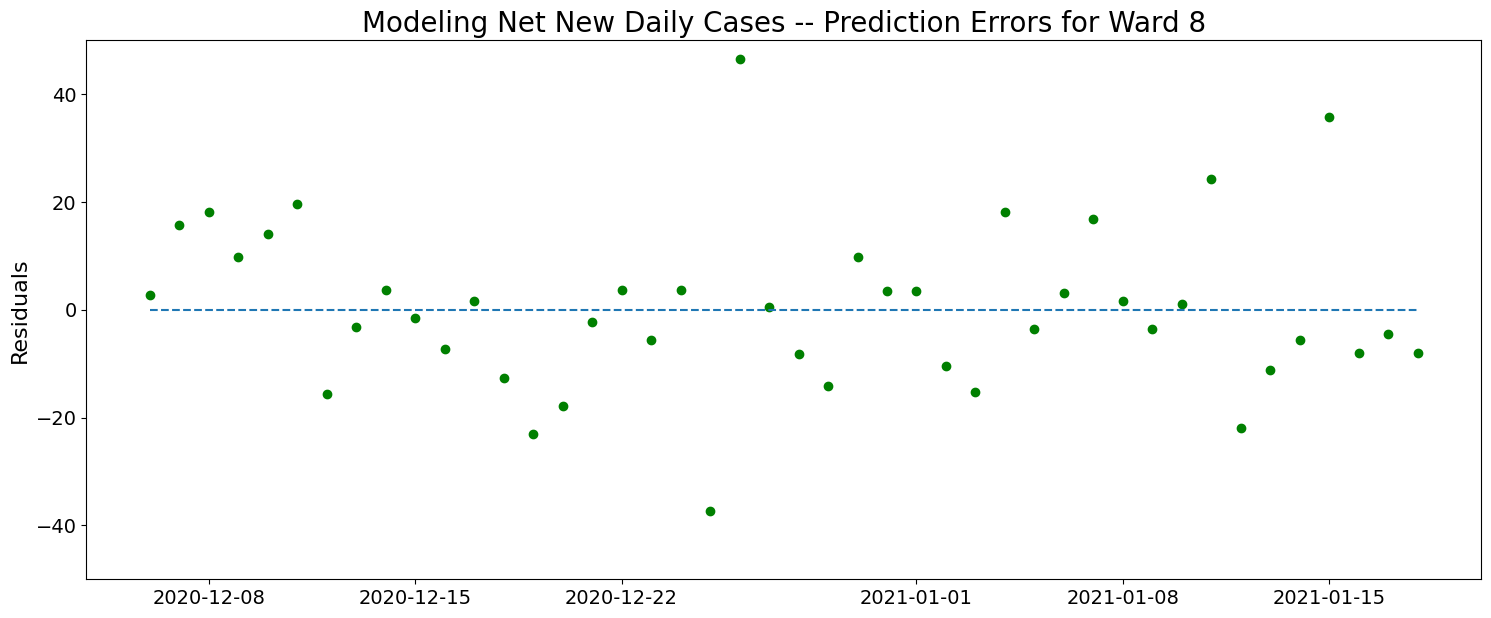

In [147]:
# Residuals for Ward 8 are markedly higher than the residuals for Ward 3. 
plot_resids(8, resids_8)